In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import os
pd.options.display.max_rows=100
import sys
sys.path.append('../../src/')

In [2]:
# pd.read_feather('../pred_feature.feather')

In [3]:
def visualize_breath(data):
    _id = data["breath_id"].iloc[0]
    r = data["R"].iloc[0]
    c = data["C"].iloc[0]
    print("total rows {}".format(len(data)))
    print("R {}, C {}".format(r, c))
    data.plot(
        x="time_step", y=["u_in", "u_out", "pressure",'preds'], title="breath id {}".format(_id)
    )


In [4]:
DATA_DIR = '/mnt/disks/extra_data/kaggle/ventilator_prediction/'
R_MAP = {5: 0, 50: 1, 20: 2}
C_MAP = {20: 0, 50: 1, 10: 2}

In [5]:
train = pd.read_csv(os.path.join(DATA_DIR,'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR,'test.csv'))


In [6]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [7]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [8]:
preds = pd.read_feather('../oofs/LSTMDpRelu-Transformer-concat-skip-classify-smooth-CE-dp-0.4-10-folds.feather')

In [9]:
preds.head()

,pressure,id,breath_id,R,C,u_out,preds
0,6.259305,241,3,1,1,0,6.259305
1,5.767190,242,3,1,1,0,5.696887
2,6.540513,243,3,1,1,0,6.540513
3,8.649578,244,3,1,1,0,8.860484
4,10.758642,245,3,1,1,0,11.039850


In [10]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [11]:
# m = train.merge(preds[['id','preds']],on='id',how='left')[['id','preds']]
# m.preds = m.preds.fillna(-1)

In [12]:
# m.to_feather('../pred_feature.feather')

In [13]:
preds.shape

(2290968, 7)

In [14]:
preds = preds.merge(train[['id','u_in','time_step']],on='id')

In [15]:
preds.head()

,pressure,id,breath_id,R,C,u_out,preds,u_in,time_step
0,6.259305,241,3,1,1,0,6.259305,0.000000,0.000000
1,5.767190,242,3,1,1,0,5.696887,1.262539,0.031854
2,6.540513,243,3,1,1,0,6.540513,4.001352,0.063761
3,8.649578,244,3,1,1,0,8.860484,6.379411,0.096498
4,10.758642,245,3,1,1,0,11.039850,8.295194,0.128229


In [16]:
preds.R = preds.R.map({v:k for k,v in R_MAP.items()})
preds.C = preds.C.map({v:k for k,v in C_MAP.items()})


In [17]:
preds['error'] = (preds['pressure'] - preds['preds']).abs()

In [44]:
(preds['pressure'] - preds['preds']).abs().mean()

0.14785470642327017

In [45]:
preds.head()

,pressure,id,breath_id,R,C,u_out,preds,u_in,time_step,error
0,6.259305,241,3,50,50,0,6.259305,0.000000,0.000000,5.430839e-08
1,5.767190,242,3,50,50,0,5.696887,1.262539,0.031854,7.030207e-02
2,6.540513,243,3,50,50,0,6.540513,4.001352,0.063761,1.209460e-07
3,8.649578,244,3,50,50,0,8.860484,6.379411,0.096498,2.109066e-01
4,10.758642,245,3,50,50,0,11.039850,8.295194,0.128229,2.812083e-01


In [58]:
error_df = preds.groupby('breath_id')['error'].mean().reset_index(name='MAE')
error_df = error_df.merge(preds[['breath_id','R','C']].drop_duplicates(),on='breath_id')

In [60]:
error_df.head()

,breath_id,MAE,R,C
0,0,0.112484,20,50
1,1,0.162422,20,20
2,2,0.059318,50,20
3,3,0.155983,50,50
4,4,0.029091,5,50


In [33]:
rc_error = preds.groupby(['R','C'])['error'].mean().reset_index(name='MAE')
rc_error

,R,C,MAE
0,5,10,0.153953
1,5,20,0.096042
2,5,50,0.097449
3,20,10,0.149339
4,20,20,0.144606
5,20,50,0.147811
6,50,10,0.176063
7,50,20,0.236053
8,50,50,0.237663


In [66]:
rc_error = preds.groupby(['R'])['error'].mean().reset_index(name='MAE')
rc_error

,R,MAE
0,5,0.107848
1,20,0.134731
2,50,0.188923


In [47]:
# m = error_df[error_df.breath_id.isin(preds[(preds.R==50)&(preds.C==50)].breath_id.unique())]
# m = m.merge(preds[(preds.R==50)&(preds.C==50)&(preds.u_out==0)].groupby('breath_id').size().reset_index(name='len_zero_uout'),on='breath_id')

In [43]:
# m.groupby('len_zero_uout')['MAE'].mean()

In [78]:
error_df[(error_df.R==50)&(error_df.C==10)].sort_values('MAE',ascending=0).head(20)

,breath_id,MAE,R,C
65863,65863,10.504763,50,10
44851,44851,9.544868,50,10
14665,14665,5.804321,50,10
5570,5570,5.312499,50,10
40815,40815,4.472974,50,10
54741,54741,4.464186,50,10
43770,43770,4.447178,50,10
66046,66046,4.415854,50,10
59525,59525,4.413657,50,10
43098,43098,4.409263,50,10


total rows 32
R 50, C 10


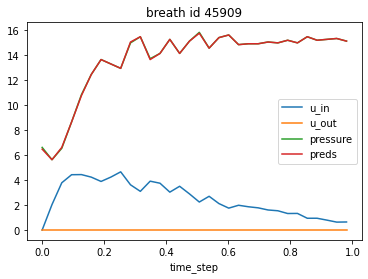

In [77]:
visualize_breath(preds[preds.breath_id==45909])

total rows 32
R 50, C 10


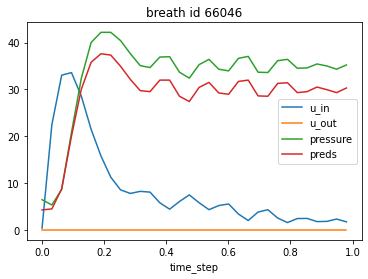

In [86]:
visualize_breath(preds[preds.breath_id==66046])


In [35]:
preds['is_uin_zero'] = (preds['u_in']==0).astype('int')
error_df = error_df.merge(preds.groupby('breath_id')['is_uin_zero'].mean().reset_index(name='num_uin_zero'),on='breath_id')

In [43]:
error_df.sort_values('MAE',ascending=False).head(10)

,breath_id,MAE,num_uin_zero
44851,44851,21.220432,0.923077
133,133,10.995256,0.033333
65863,65863,10.483131,0.884615
17647,17647,5.865835,0.031250
5570,5570,4.944584,0.000000
71850,71850,4.885999,0.000000
14108,14108,4.576230,0.031250
48184,48184,4.567371,0.000000
58452,58452,4.550892,0.166667
54741,54741,4.536686,0.000000


In [37]:
error_df.sort_values('num_uin_zero',ascending=False).head(10)

,breath_id,MAE,num_uin_zero
48648,48648,0.067959,1.0
15827,15827,0.096080,1.0
25134,25134,0.048484,1.0
31781,31781,0.074838,1.0
10387,10387,0.083484,1.0
48892,48892,1.701312,1.0
61051,61051,0.446055,1.0
37578,37578,1.034760,1.0
35639,35639,0.055757,1.0
55108,55108,2.001268,1.0


In [53]:
preds.head()

,pressure,id,breath_id,R,C,u_out,preds,u_in,error
0,6.259305,241,3,1,1,0,6.681118,0.000000,4.218130e-01
1,5.767190,242,3,1,1,0,5.626585,1.262539,1.406041e-01
2,6.540513,243,3,1,1,0,6.540513,4.001352,1.209460e-07
3,8.649578,244,3,1,1,0,8.790182,6.379411,1.406046e-01
4,10.758642,245,3,1,1,0,10.899246,8.295194,1.406043e-01


In [21]:
preds[preds.breath_id==26455]

,pressure,id,breath_id,R,C,u_out,preds,u_in,error,is_uin_zero
1076929,4.290845,2116401,26455,1,2,0,6.259305,0.0,1.968460,1
1076930,4.290845,2116402,26455,1,2,0,5.345376,0.0,1.054532,1
1076931,4.290845,2116403,26455,1,2,0,5.978096,0.0,1.687252,1
1076932,4.431449,2116404,26455,1,2,0,5.978096,0.0,1.546647,1
1076933,4.290845,2116405,26455,1,2,0,5.978096,0.0,1.687252,1
1076934,4.361147,2116406,26455,1,2,0,6.048398,0.0,1.687251,1
1076935,4.290845,2116407,26455,1,2,0,6.048398,0.0,1.757554,1
1076936,4.361147,2116408,26455,1,2,0,6.048398,0.0,1.687251,1
1076937,4.290845,2116409,26455,1,2,0,6.048398,0.0,1.757554,1
1076938,4.220542,2116410,26455,1,2,0,5.978096,0.0,1.757554,1


In [1]:
import pandas as pd

In [28]:
# pred1 = pd.read_csv('../subs/baseline_LSTM_Classification.csv')
# pred2 = pd.read_csv('../subs/v0-LSTM-classification-top3-smooth-loss.csv')
# pred3 = pd.read_csv('../subs/v0-LSTM-classification-top3-smooth-loss.csv')
pred1 = pd.read_csv('../subs/LSTMDpRelu-Transformer-concat-skip-classify-smooth-CE-dp-0.4.csv')
pred2 = pd.read_csv('../data/median_submission_139.csv')
pred3 = pd.read_csv('../subs/LSTMDpRelu-Transformer-concat-skip-classify-smooth-CE-dp-0.4-10-folds.csv')
pred4 = pd.read_csv('../subs/v0-LSTM-classification-top3-smooth-loss.csv')

In [29]:
m = pd.concat([pred1.pressure,pred2.pressure,pred3.pressure,pred4.pressure],axis=1)

In [30]:
m.head()

,pressure,pressure,pressure,pressure
0,6.259305,6.329647,6.259305,6.259305
1,5.907794,5.978134,5.907794,5.907794
2,7.032628,7.102974,7.102931,7.102931
3,7.524743,7.665394,7.595046,7.595046
4,9.141692,9.212049,9.176844,9.141692


In [31]:
m.corr()

,pressure,pressure,pressure,pressure
pressure,1.000000,0.868998,0.997452,0.987724
pressure,0.868998,1.000000,0.873708,0.843471
pressure,0.997452,0.873708,1.000000,0.987731
pressure,0.987724,0.843471,0.987731,1.000000


In [32]:
pred3['pressure'] = m.median(axis=1)

In [33]:
pred3

,id,pressure
0,1,6.259305
1,2,5.907794
2,3,7.102931
3,4,7.595046
4,5,9.159268
...,...,...
4023995,4023996,0.000000
4023996,4023997,0.000000
4023997,4023998,0.000000
4023998,4023999,0.000000


In [32]:
# pred4["pressure"] = np.round( (submission.pressure - PRESSURE_MIN)/PRESSURE_STEP ) * PRESSURE_STEP + PRESSURE_MIN

In [34]:
import numpy as np

In [14]:
# pred4["pressure"] =\
# np.round( (pred4.pressure - PRESSURE_MIN)/PRESSURE_STEP ) * PRESSURE_STEP + PRESSURE_MIN

In [15]:
# (pred4["pressure"]==a).value_counts()

In [35]:
pred3.to_csv('ensemble_139_139_135_146_median.csv',index=False)

In [12]:
pred1['id'].values

array([      1,       2,       3, ..., 4023998, 4023999, 4024000])

In [14]:
pred4.shape

(2419884, 2)

In [10]:
import pandas as pd
a1 = pd.read_csv('../data/test_v61.csv')
a2 = pd.read_csv('v61_median.csv')

In [15]:
(a1['preds'].round(5)==a2['pressure'].round(5)).value_counts()

True    4024000
dtype: int64

In [7]:
a = a1.merge(a2,on='id')

In [19]:
a1.head()

,id,breath_id,R,C,time_step,u_in,u_out,preds
0,1,0,5,20,0.000000,0.000000,0,6.259305
1,2,0,5,20,0.031904,7.515046,0,5.907794
2,3,0,5,20,0.063827,14.651675,0,7.173232
3,4,0,5,20,0.095751,21.230610,0,7.665347
4,5,0,5,20,0.127644,26.320956,0,9.141693


In [16]:
# d1 = pd.read_csv('v61_test_preds_correct.csv')
# d1=pd.read_csv('../data/test_v61.csv')
d1=pd.read_csv('v61_median.csv')
d2 = pd.read_csv('regression_sub.csv')
d3 = pd.read_csv('v63_test_preds.csv')
# d1.drop('preds.1',axis=1,inplace=True)
m = pd.concat([d3.preds,d3.preds,d3.preds,d2.pressure,d2.pressure],axis=1)

In [17]:
temp = d1.merge(d2,on='id')
(temp[temp.u_out==0].pressure==temp[temp.u_out==0].preds).value_counts()

AttributeError: 'DataFrame' object has no attribute 'u_out'

In [15]:
(d1.preds==d3.preds).value_counts()

True     3536382
False     487618
Name: preds, dtype: int64

In [38]:
m1 = pd.concat([d1.preds,d1.preds,d1.preds,d2.pressure,d2.pressure,d3.preds],axis=1)

In [50]:
(m1.median(axis=1)==m.median(axis=1)).value_counts(1)

True    1.0
dtype: float64

In [42]:
(d2.pressure==m.median(axis=1)).value_counts(1)

False    0.5
True     0.5
dtype: float64

In [52]:
(d2.pressure.round(4)==d3.preds.round(4)).value_counts(1)

True     0.850748
False    0.149252
dtype: float64

In [48]:
(d2.pressure.round(4)==m.median(axis=1).round(4)).value_counts(1)

True     0.850748
False    0.149252
dtype: float64

In [53]:
(d3.preds.round(4)==m.median(axis=1).round(4)).value_counts(1)

True    1.0
dtype: float64

In [33]:
m.head()

,preds,preds,preds,pressure,pressure,preds
0,6.259305,6.259305,6.259305,6.259305,6.259305,6.259305
1,5.907794,5.907794,5.907794,5.907794,5.907794,5.907794
2,7.173232,7.173232,7.173232,7.173232,7.173232,7.173232
3,7.665347,7.665347,7.665347,7.665347,7.665347,7.665347
4,9.141693,9.141693,9.141693,9.141693,9.141693,9.141693


In [34]:
m.median(axis=1)

0          6.259305
1          5.907794
2          7.173232
3          7.665347
4          9.141693
             ...   
4023995    0.000000
4023996    0.000000
4023997    0.000000
4023998    0.000000
4023999    0.000000
Length: 4024000, dtype: float64

In [35]:
d2['pressure'] = m.median(axis=1)

In [36]:
d2.to_csv('ensemble.csv',index=False)